In [1]:
import pickle, gzip
with gzip.open("Dataset/asi_color.pkl.gz", "rb") as f:
    asi = pickle.load(f)

#### Integrate seg_df to asi

In [2]:
# ============================================
# Single-cell: CVAT dataset -> seg_df (with sky-crop + timestamps)
# ============================================

# ---------- CONFIG ----------
from pathlib import Path
ROOT = Path("Dataset/cvat_dataset")               # <-- change if needed
IMG_GLOB = str(ROOT/"*/JPEGImages/*.jpg")
MSK_GLOB = str(ROOT/"*/SegmentationClass/*.png")

CROPPING_ZIP     = "cropping.zip"                 # same style as your ASI pipeline
APPLY_SKY_CROP   = True                           # <- ensures NameError won't happen
OUTSIDE_BEHAVIOR = "ignore"                       # "ignore" (recommended) or "background"

# Raw values for cropping on RAW masks
BACKGROUND_RAW_RGB   = 0                          # used if OUTSIDE_BEHAVIOR="background" (RGB masks)
IGNORE_RAW_RGB       = 224                        # used if OUTSIDE_BEHAVIOR="ignore" (RGB masks)
IGNORE_RAW_INDEXED   = 255                        # used if OUTSIDE_BEHAVIOR="ignore" (indexed masks)

# Final class ids
CLASS_IDS = {"bg":0, "low":1, "mid":2, "high":3}
NUM_CLASSES = 4

# ---------- IMPORTS ----------
import re, zipfile, xml.etree.ElementTree as ET
from datetime import datetime
import numpy as np, pandas as pd, cv2, glob
from PIL import Image

# ---------- Timestamp parsing ----------
_RX_TS = re.compile(r'(\d{8})_(\d{4})')  # YYYYMMDD_HHMM

def parse_dt_from_filename(fpath: str) -> dict:
    name = Path(fpath).name
    m = _RX_TS.search(name)
    if not m:
        return {"timestamp": pd.NaT, "DDMMYYYY": None, "HH:MM:SS": None,
                "year": None, "month": None, "day": None, "hour": None, "minute": None}
    ymd, hm = m.group(1), m.group(2)
    dt = datetime.strptime(f"{ymd}_{hm}", "%Y%m%d_%H%M")
    return {
        "timestamp": pd.Timestamp(dt),
        "DDMMYYYY": dt.strftime("%d%m%Y"),
        "HH:MM:SS": dt.strftime("%H:%M:%S"),
        "year": dt.year, "month": dt.month, "day": dt.day, "hour": dt.hour, "minute": dt.minute
    }

def _year_from_filename(fname: str):
    m = re.search(r'(\d{4})\d{4}_\d{4}', Path(fname).stem)
    return int(m.group(1)) if m else None

# ---------- Cropping XML parsing (CVAT & LabelMe) ----------
def _to_int_or_none(v):
    try: return int(v)
    except: return None

def _parse_points_str(s: str):
    pts = []
    for pair in (s or "").strip().split(";"):
        if not pair: continue
        x, y = pair.split(",")
        pts.append((float(x), float(y)))
    return pts

def _extract_polygons_any(xml_bytes: bytes):
    root = ET.fromstring(xml_bytes)
    # CVAT
    img_nodes = root.findall(".//image")
    if img_nodes:
        im = img_nodes[0]
        width  = _to_int_or_none(im.attrib.get("width"))
        height = _to_int_or_none(im.attrib.get("height"))
        name   = im.attrib.get("name")
        polys  = []
        for p in im.findall(".//polygon"):
            pts = _parse_points_str(p.attrib.get("points"))
            if len(pts) >= 3: polys.append(pts)
        return {"width": width, "height": height, "name": name, "polygons": polys}
    # LabelMe
    name = (root.findtext("./filename") or root.findtext(".//image/filename") or None)
    height = _to_int_or_none(root.findtext(".//imagesize/nrows")) or \
             _to_int_or_none(root.findtext(".//size/height"))     or \
             _to_int_or_none(root.findtext(".//image/height"))
    width  = _to_int_or_none(root.findtext(".//imagesize/ncols")) or \
             _to_int_or_none(root.findtext(".//size/width"))      or \
             _to_int_or_none(root.findtext(".//image/width"))
    polys = []
    for obj in root.findall(".//object"):
        poly = obj.find("./polygon")
        if poly is None: continue
        pts = []
        for pt in poly.findall("./pt"):
            x = pt.findtext("./x"); y = pt.findtext("./y")
            if x is None or y is None: continue
            pts.append((float(x), float(y)))
        if len(pts) >= 3: polys.append(pts)
    return {"width": width, "height": height, "name": name, "polygons": polys}

def load_cropping_xml_zip(zip_path: str):
    by_stem, by_year = {}, {}
    with zipfile.ZipFile(zip_path, "r") as zf:
        xml_files = [f for f in zf.namelist() if f.lower().endswith(".xml")]
        for xf in xml_files:
            meta = _extract_polygons_any(zf.read(xf))
            stem = Path(xf).stem
            year = _year_from_filename(xf)
            rec = {"width": meta["width"], "height": meta["height"],
                   "polygons": meta["polygons"], "stem": stem,
                   "year": year, "name": meta["name"]}
            by_stem[stem] = rec
            if year is not None:
                by_year.setdefault(year, []).append(rec)
    return by_stem, by_year

# ---------- Polygon utils ----------
def _scale_polygons(polys, src_w, src_h, dst_w, dst_h):
    if not polys or src_w is None or src_h is None or (src_w==dst_w and src_h==dst_h):
        return polys
    sx, sy = float(dst_w)/float(src_w), float(dst_h)/float(src_h)
    return [[(x*sx, y*sy) for (x,y) in poly] for poly in polys]

def rasterize_polygons(h, w, polygons):
    mask = np.zeros((h, w), dtype=np.uint8)
    for pts in polygons or []:
        if len(pts) < 3: continue
        arr = np.array(pts, dtype=np.int32).reshape(-1,1,2)
        cv2.fillPoly(mask, [arr], 1)
    return mask  # 1 = non-sky

def choose_annotation_for_image(img_path: str, xml_by_stem, xml_by_year):
    stem = Path(img_path).stem
    if xml_by_stem and (stem in xml_by_stem) and xml_by_stem[stem]["polygons"]:
        return xml_by_stem[stem]
    y = parse_dt_from_filename(img_path)["year"]
    if (xml_by_year is not None) and (y is not None) and (y in xml_by_year):
        for rec in xml_by_year[y]:
            if rec["polygons"]:
                return rec
    return None

# ---------- Mask helpers ----------
def load_mask_rgb(path: Path) -> np.ndarray:
    return np.array(Image.open(path))

def load_mask_indices(path: Path) -> np.ndarray:
    arr = np.array(Image.open(path))
    if arr.ndim == 3:
        arr = arr[...,0]
    return arr.astype(np.uint8)

def quantize_raw_values(v: np.ndarray) -> np.ndarray:
    if v.ndim == 3:
        v = v[...,0]
    q = (v // 64) * 64
    return np.clip(q, 0, 224).astype(np.uint16)

def remap_quantized_to_classes(q: np.ndarray) -> np.ndarray:
    out = np.full(q.shape, -1, dtype=np.int16)
    out[q == 0]   = 0
    out[q == 64]  = 1
    out[q == 128] = 2
    out[q == 192] = 3
    out[q >= 224] = -1
    return out  # {-1,0,1,2,3}

def remap_indices_to_classes(idx: np.ndarray) -> np.ndarray:
    # Default mapping for CVAT 1.1 indexed: 0:bg,1:low,2:mid,3:high,255:ignore
    out = np.full(idx.shape, -1, dtype=np.int16)
    out[idx == 0]   = 0
    out[idx == 1]   = 1
    out[idx == 2]   = 2
    out[idx == 3]   = 3
    out[idx == 255] = -1
    # Unknown values -> bg
    known = (idx==0)|(idx==1)|(idx==2)|(idx==3)|(idx==255)
    out[~known] = 0
    return out

def apply_sky_crop_raw(raw_arr: np.ndarray, ann_rec: dict,
                       outside_behavior="ignore",
                       background_raw=0, ignore_raw=224) -> np.ndarray:
    """Apply non-sky polygons on RAW (RGB or single-channel)."""
    if ann_rec is None or not ann_rec.get("polygons"):
        return raw_arr
    if raw_arr.ndim == 3:
        h, w, ch = raw_arr.shape
    else:
        h, w = raw_arr.shape; ch = None
    pw, ph = ann_rec.get("width"), ann_rec.get("height")
    polys = _scale_polygons(ann_rec["polygons"], pw, ph, w, h)
    non_sky = rasterize_polygons(h, w, polys)
    out = raw_arr.copy()
    if outside_behavior == "ignore":
        if ch is None:
            out[non_sky==1] = ignore_raw
        else:
            out[non_sky==1] = np.array([ignore_raw]*ch, dtype=out.dtype)
    else:
        if ch is None:
            out[non_sky==1] = background_raw
        else:
            out[non_sky==1] = np.array([background_raw]*ch, dtype=out.dtype)
    return out

def build_sky_mask_like(h: int, w: int, ann_rec: dict):
    if ann_rec is None or not ann_rec.get("polygons"):
        return None
    pw, ph = ann_rec.get("width"), ann_rec.get("height")
    polys = _scale_polygons(ann_rec["polygons"], pw, ph, w, h)
    non_sky = rasterize_polygons(h, w, polys)
    return (non_sky == 0).astype(np.uint8)  # 1=sky, 0=non-sky

# ---------- Scan & pair ----------
imgs = sorted(glob.glob(IMG_GLOB, recursive=True))
msks = sorted(glob.glob(MSK_GLOB, recursive=True))

img_df = pd.DataFrame({"img_path": imgs})
img_df["stem"] = img_df["img_path"].apply(lambda p: Path(p).stem)
img_df = img_df.assign(**img_df["img_path"].apply(parse_dt_from_filename).apply(pd.Series))

msk_df = pd.DataFrame({"seg_path": msks})
msk_df["stem"] = msk_df["seg_path"].apply(lambda p: Path(p).stem)
msk_df = msk_df.assign(**msk_df["seg_path"].apply(parse_dt_from_filename).apply(pd.Series))

pairs = img_df.merge(msk_df, on="stem", how="inner", suffixes=("_img","_seg"))
print(f"images: {len(imgs)} | masks: {len(msks)} | pairs: {len(pairs)} | only-images: {len(set(img_df.stem)-set(msk_df.stem))} | only-masks: {len(set(msk_df.stem)-set(img_df.stem))}")

# ---------- Load cropping polygons ----------
xml_by_stem = xml_by_year = None
if APPLY_SKY_CROP and CROPPING_ZIP:
    try:
        xml_by_stem, xml_by_year = load_cropping_xml_zip(CROPPING_ZIP)
        print(f"[INFO] Loaded cropping XML: {CROPPING_ZIP} ({len(xml_by_stem)} stems, {len(xml_by_year)} years)")
    except Exception as e:
        print(f"[WARN] Failed to load cropping ZIP: {e}. Proceeding without sky-crop.")
        APPLY_SKY_CROP = False

# ---------- Build seg_df ----------
records = []
for row in pairs.itertuples(index=False):
    # prefer mask timestamp; fallback to image timestamp
    ts_mask = getattr(row, "timestamp_seg")
    ts_img  = getattr(row, "timestamp_img")
    ts = ts_mask if pd.notna(ts_mask) else ts_img
    if pd.isna(ts):
        continue
    ts = pd.Timestamp(ts)

    # read mask and detect format
    arr = np.array(Image.open(row.seg_path))
    is_indexed_like = (arr.ndim == 2) and set(np.unique(arr)).issubset({0,1,2,3,255})

    if is_indexed_like:
        # indexed palette path (e.g., Segmentation mask 1.1)
        raw = arr  # (H,W) uint8 of indices
        ann = choose_annotation_for_image(row.seg_path, xml_by_stem, xml_by_year) if APPLY_SKY_CROP else None
        raw = apply_sky_crop_raw(raw, ann,
                                 outside_behavior=OUTSIDE_BEHAVIOR,
                                 background_raw=0,          # background index
                                 ignore_raw=IGNORE_RAW_INDEXED)  # 255
        lab = remap_indices_to_classes(raw)                 # {-1,0..3}
        H, W = lab.shape
        sky_mask = build_sky_mask_like(H, W, ann) if ann is not None else None
    else:
        # RGB (VOC-style) path
        raw = arr                                          # (H,W,3)
        ann = choose_annotation_for_image(row.seg_path, xml_by_stem, xml_by_year) if APPLY_SKY_CROP else None
        raw = apply_sky_crop_raw(raw, ann,
                                 outside_behavior=OUTSIDE_BEHAVIOR,
                                 background_raw=BACKGROUND_RAW_RGB,
                                 ignore_raw=IGNORE_RAW_RGB)        # 224
        q   = quantize_raw_values(raw)                      # (H,W)
        lab = remap_quantized_to_classes(q)                 # (H,W) int16
        H, W = lab.shape
        sky_mask = build_sky_mask_like(H, W, ann) if ann is not None else None

        # sanity warn if unexpected values
        v = raw[...,0] if raw.ndim==3 else raw
        bad = np.setdiff1d(np.unique(v), np.array([0,32,64,96,128,160,192,224]))
        if bad.size:
            print("WARN:", Path(row.seg_path).name, "unexpected raw values (showing first 10):", bad[:10])

    uniq = np.unique(lab[lab!=-1]) if (lab==-1).any() else np.unique(lab)

    records.append({
        "stem": row.stem,
        "img_path": row.img_path,
        "seg_path": row.seg_path,
        "timestamp": ts,
        "DDMMYYYY": ts.strftime("%d%m%Y"),
        "HH:MM:SS": ts.strftime("%H:%M:%S"),
        "year": ts.year, "month": ts.month, "day": ts.day, "hour": ts.hour, "minute": ts.minute,
        "mask_np": lab,               # (H,W) int16 in {-1,0,1,2,3}
        "sky_mask": sky_mask,         # None or (H,W) uint8 (1=sky,0=non-sky)
        "H": int(H), "W": int(W),
        "n_classes_found": int(uniq.size),
        "has_mask": True,
        "ts_match_img_seg": (pd.notna(ts_mask) and pd.notna(ts_img) and (pd.Timestamp(ts_mask) == pd.Timestamp(ts_img)))
    })

seg_df = pd.DataFrame(records).sort_values("timestamp").reset_index(drop=True)
print(f"\nseg_df rows: {len(seg_df)} | sky_mask available: {seg_df['sky_mask'].notna().sum()}")
display(seg_df[["timestamp","img_path","seg_path","H","W","n_classes_found","ts_match_img_seg"]].head(10))


images: 220 | masks: 218 | pairs: 218 | only-images: 2 | only-masks: 0
[INFO] Loaded cropping XML: cropping.zip (3 stems, 3 years)
WARN: 20230611_1405_hdr.png unexpected raw values (showing first 10): [109 156 164]
WARN: 20230612_1535_hdr.png unexpected raw values (showing first 10): [109 156 164]
WARN: 20240503_1255_hdr.png unexpected raw values (showing first 10): [109 156 164]
WARN: 20240507_1157_hdr.png unexpected raw values (showing first 10): [109 156 164]
WARN: 20240513_0936_hdr.png unexpected raw values (showing first 10): [109 156 164]
WARN: 20241029_1610_hdr.png unexpected raw values (showing first 10): [109 156 164]
WARN: 20241031_1319_hdr.png unexpected raw values (showing first 10): [109 156 164]
WARN: 20241105_0715_hdr.png unexpected raw values (showing first 10): [109 156 164]
WARN: 20241201_1041_hdr.png unexpected raw values (showing first 10): [164]
WARN: 20241202_1055_hdr.png unexpected raw values (showing first 10): [109 156 164]
WARN: 20250220_1628.png unexpected ra

,timestamp,img_path,seg_path,H,W,n_classes_found,ts_match_img_seg
0,2023-06-11 14:05:00,Dataset\cvat_dataset\0\JPEGImages\20230611_140...,Dataset\cvat_dataset\0\SegmentationClass\20230...,2080,3096,4,True
1,2023-06-12 15:35:00,Dataset\cvat_dataset\0\JPEGImages\20230612_153...,Dataset\cvat_dataset\0\SegmentationClass\20230...,2080,3096,4,True
2,2024-05-03 12:55:00,Dataset\cvat_dataset\0\JPEGImages\20240503_125...,Dataset\cvat_dataset\0\SegmentationClass\20240...,2080,3096,4,True
3,2024-05-07 11:57:00,Dataset\cvat_dataset\0\JPEGImages\20240507_115...,Dataset\cvat_dataset\0\SegmentationClass\20240...,2080,3096,4,True
4,2024-05-13 09:36:00,Dataset\cvat_dataset\0\JPEGImages\20240513_093...,Dataset\cvat_dataset\0\SegmentationClass\20240...,2080,3096,4,True
5,2024-10-29 16:10:00,Dataset\cvat_dataset\0\JPEGImages\20241029_161...,Dataset\cvat_dataset\0\SegmentationClass\20241...,2080,3096,4,True
6,2024-10-31 13:19:00,Dataset\cvat_dataset\0\JPEGImages\20241031_131...,Dataset\cvat_dataset\0\SegmentationClass\20241...,2080,3096,4,True
7,2024-11-05 07:15:00,Dataset\cvat_dataset\0\JPEGImages\20241105_071...,Dataset\cvat_dataset\0\SegmentationClass\20241...,2080,3096,4,True
8,2024-12-01 10:41:00,Dataset\cvat_dataset\0\JPEGImages\20241201_104...,Dataset\cvat_dataset\0\SegmentationClass\20241...,2080,3096,3,True
9,2024-12-02 10:55:00,Dataset\cvat_dataset\0\JPEGImages\20241202_105...,Dataset\cvat_dataset\0\SegmentationClass\20241...,2080,3096,4,True


In [3]:
# ============================================
# Integrate seg_df (images + masks) into ASI schema
#  - exact-minute join to existing ASI rows
#  - add new rows for unmatched segmented images
# ============================================

import pandas as pd
from pathlib import Path
import numpy as np

# --- CONFIG ---
EXTRA_SOURCE_NAME = "cvat_extra"   # will be placed into crop_source for added rows
LOAD_IMAGES_IN_MEMORY = False      # set True to actually load RGB into 'image' for added rows

def _load_rgb(p):
    import cv2
    im = cv2.imread(p, cv2.IMREAD_COLOR)
    if im is None: return None
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

# 0) Safety: normalize timestamps to minute precision
asi_ = asi.copy()
asi_["timestamp"] = pd.to_datetime(asi_["timestamp"], errors="coerce").dt.floor("min")

seg_ = seg_df.copy()
seg_["timestamp"] = pd.to_datetime(seg_["timestamp"], errors="coerce").dt.floor("min")

# 1) Columns to carry from seg_df into ASI
seg_cols = ["timestamp", "seg_path", "mask_np", "sky_mask", "H", "W", "n_classes_found", "has_mask"]
seg_cols = [c for c in seg_cols if c in seg_.columns]  # guard

# 2) Left-join segmentation onto existing ASI rows (exact minute)
asi_joined = (asi_
    .merge(seg_[seg_cols], on="timestamp", how="left", suffixes=("","_seg"))
)

# Fill/ensure has_mask exists
if "has_mask" not in asi_joined.columns:
    asi_joined["has_mask"] = asi_joined["seg_path"].notna()
else:
    asi_joined["has_mask"] = asi_joined["has_mask"].fillna(False) | asi_joined["seg_path"].notna()

attached_cnt = int(asi_joined["seg_path"].notna().sum())
print(f"[Attach] Segmentation attached to existing ASI rows: {attached_cnt}")

# 3) Build rows for segmented images NOT present in ASI (by timestamp)
asi_keys = set(asi_["timestamp"].dropna().unique())
seg_unmatched = seg_.loc[~seg_["timestamp"].isin(asi_keys)].copy()

# Prepare ASI-schema columns
asi_cols = ['index', 'timestamp', 'filepath', 'DDMMYYYY', 'HH:MM:SS', 'year',
            'month', 'day', 'hour', 'minute', 'crop_source', 'crop_year', 'image', 'sky_mask']

# For unmatched seg rows, create ASI-shaped rows + seg columns
rows = []
for r in seg_unmatched.itertuples(index=False):
    ts = pd.Timestamp(r.timestamp)
    row = {
        # ASI schema
        'index': None,  # you can renumber later if needed
        'timestamp': ts,
        'filepath': getattr(r, "img_path", None),
        'DDMMYYYY': ts.strftime("%d%m%Y"),
        'HH:MM:SS': ts.strftime("%H:%M:%S"),
        'year': ts.year, 'month': ts.month, 'day': ts.day, 'hour': ts.hour, 'minute': ts.minute,
        'crop_source': EXTRA_SOURCE_NAME,
        'crop_year': ts.year,
        'image': _load_rgb(getattr(r, "img_path")) if LOAD_IMAGES_IN_MEMORY and hasattr(r, "img_path") else None,
        'sky_mask': getattr(r, "sky_mask", None),

        # Segmentation fields to carry over
        'seg_path': getattr(r, "seg_path", None),
        'mask_np': getattr(r, "mask_np", None),
        'H': getattr(r, "H", None),
        'W': getattr(r, "W", None),
        'n_classes_found': getattr(r, "n_classes_found", None),
        'has_mask': True
    }
    rows.append(row)

asi_extra = pd.DataFrame(rows)

added_cnt = len(asi_extra)
print(f"[Add] New ASI-style rows created from segmented images: {added_cnt}")

# 4) Union: ASI (with joined seg) + new rows
# Ensure both frames have same columns before concat
all_cols = list(dict.fromkeys(list(asi_joined.columns) + list(asi_extra.columns)))  # preserve order
asi_joined = asi_joined.reindex(columns=all_cols)
asi_extra  = asi_extra.reindex(columns=all_cols)

asi_with_seg = pd.concat([asi_joined, asi_extra], ignore_index=True)

# 5) (Optional) Deduplicate if any exact duplicate timestamps+filepath appear
if {"timestamp","filepath"}.issubset(asi_with_seg.columns):
    before = len(asi_with_seg)
    # Prefer rows that have a seg_path (drop duplicates keeping the last occurrence with seg)
    asi_with_seg["_has_seg_int"] = asi_with_seg["seg_path"].notna().astype(int)
    asi_with_seg = (asi_with_seg
                    .sort_values(["timestamp","_has_seg_int"])   # seg rows last => kept by keep='last'
                    .drop_duplicates(subset=["timestamp","filepath"], keep="last")
                    .drop(columns="_has_seg_int")
                    .reset_index(drop=True))
    after = len(asi_with_seg)
    if after < before:
        print(f"[Dedup] Dropped {before-after} duplicate (timestamp, filepath) rows (kept rows with segmentation).")

# 6) (Optional) Reassign a clean sequential 'index' if you want
if 'index' in asi_with_seg.columns:
    try:
        # If original ASI 'index' is numeric and you want to keep existing ones, only fill NA
        max_idx = pd.to_numeric(asi_with_seg['index'], errors='coerce').max()
        if pd.isna(max_idx): max_idx = -1
        na_mask = asi_with_seg['index'].isna()
        asi_with_seg.loc[na_mask, 'index'] = np.arange(int(max_idx)+1, int(max_idx)+1 + na_mask.sum())
        asi_with_seg['index'] = asi_with_seg['index'].astype(int)
    except Exception as e:
        print("[Index] Skipped reindexing:", e)

print(f"[Result] ASI total rows: {len(asi_with_seg)} | with seg: {int(asi_with_seg['has_mask'].fillna(False).sum())}")

# Preview a few attached and a few newly added
cols_show = ['timestamp','filepath','seg_path','has_mask','H','W','n_classes_found','crop_source']
print("\nSample rows WITH segmentation (from both attach & add):")
display(asi_with_seg.loc[asi_with_seg["has_mask"]==True, cols_show].head(10))

print("\nSample rows WITHOUT segmentation (original ASI only):")
display(asi_with_seg.loc[asi_with_seg["has_mask"]!=True, ['timestamp','filepath','crop_source']].head(10))


C:\Users\bdan569\AppData\Local\Temp\ipykernel_17048\3672717442.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  asi_joined["has_mask"] = asi_joined["has_mask"].fillna(False) | asi_joined["seg_path"].notna()


[Attach] Segmentation attached to existing ASI rows: 10
[Add] New ASI-style rows created from segmented images: 208
[Result] ASI total rows: 159959 | with seg: 218

Sample rows WITH segmentation (from both attach & add):


,timestamp,filepath,seg_path,has_mask,H,W,n_classes_found,crop_source
8581,2023-06-11 14:05:00,S:\2023\06\20230611\20230611_1405_hdr.jpg,Dataset\cvat_dataset\0\SegmentationClass\20230...,True,2080.0,3096.0,4.0,20230324_1109_hdr
8736,2023-06-12 15:35:00,S:\2023\06\20230612\20230612_1535_hdr.jpg,Dataset\cvat_dataset\0\SegmentationClass\20230...,True,2080.0,3096.0,4.0,20230324_1109_hdr
41805,2024-05-03 12:55:00,S:\2024\05\20240503\20240503_1255_hdr.jpg,Dataset\cvat_dataset\0\SegmentationClass\20240...,True,2080.0,3096.0,4.0,20241203_0620_hdr
42438,2024-05-07 11:57:00,S:\2024\05\20240507\20240507_1157_hdr.jpg,Dataset\cvat_dataset\0\SegmentationClass\20240...,True,2080.0,3096.0,4.0,20241203_0620_hdr
46585,2024-05-13 09:36:00,S:\2024\05\20240513\20240513_0936_hdr.jpg,Dataset\cvat_dataset\0\SegmentationClass\20240...,True,2080.0,3096.0,4.0,20241203_0620_hdr
47202,2024-10-29 16:10:00,S:\2024\10\20241029\20241029_1610_hdr.jpg,Dataset\cvat_dataset\0\SegmentationClass\20241...,True,2080.0,3096.0,4.0,20241203_0620_hdr
48678,2024-10-31 13:19:00,S:\2024\10\20241031\20241031_1319_hdr.jpg,Dataset\cvat_dataset\0\SegmentationClass\20241...,True,2080.0,3096.0,4.0,20241203_0620_hdr
51574,2024-11-05 07:15:00,S:\2024\11\20241105\20241105_0715_hdr.jpg,Dataset\cvat_dataset\0\SegmentationClass\20241...,True,2080.0,3096.0,4.0,20241203_0620_hdr
71752,2024-12-01 10:41:00,S:\2024\12\20241201\20241201_1041_hdr.jpg,Dataset\cvat_dataset\0\SegmentationClass\20241...,True,2080.0,3096.0,3.0,20241203_0620_hdr
72745,2024-12-02 10:55:00,S:\2024\12\20241202\20241202_1055_hdr.jpg,Dataset\cvat_dataset\0\SegmentationClass\20241...,True,2080.0,3096.0,4.0,20241203_0620_hdr



Sample rows WITHOUT segmentation (original ASI only):


,timestamp,filepath,crop_source
0,2022-10-01 05:25:00,S:\2022\10\20221001\20221001_0525_hdr.jpg,None
1,2022-10-01 05:30:00,S:\2022\10\20221001\20221001_0530_hdr.jpg,None
2,2022-10-01 05:35:00,S:\2022\10\20221001\20221001_0535_hdr.jpg,None
3,2022-10-01 05:40:00,S:\2022\10\20221001\20221001_0540_hdr.jpg,None
4,2022-10-01 05:45:00,S:\2022\10\20221001\20221001_0545_hdr.jpg,None
5,2022-10-01 05:50:00,S:\2022\10\20221001\20221001_0550_hdr.jpg,None
6,2022-10-01 05:55:00,S:\2022\10\20221001\20221001_0555_hdr.jpg,None
7,2022-10-01 06:00:00,S:\2022\10\20221001\20221001_0600_hdr.jpg,None
8,2022-10-01 06:05:00,S:\2022\10\20221001\20221001_0605_hdr.jpg,None
9,2022-10-01 06:10:00,S:\2022\10\20221001\20221001_0610_hdr.jpg,None


In [4]:
# =========================================================
# REFINED: build 10×1min sequences while preserving segmentation
# =========================================================

# 1) Black-frame detector (unchanged)
def is_black_image(img, colorspace="HSV",
                   v_mean_thresh=0.01, zero_ratio_thresh=0.995):
    if img is None or not isinstance(img, np.ndarray) or img.ndim != 3:
        return True
    if colorspace.upper() == "HSV":
        V = img[..., 2]
        v_mean = float(np.nanmean(V))
        zratio = float(np.mean(V <= 1e-6))
    else:
        gray = 0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]
        v_mean = float(np.nanmean(gray))
        zratio = float(np.mean(gray <= 1e-6))
    return (v_mean < v_mean_thresh) or (zratio > zero_ratio_thresh)

def drop_black_frames(asi, colorspace="HSV"):
    ok = asi["image"].apply(lambda im: (im is not None) and (not is_black_image(im, colorspace)))
    out = asi.loc[ok].copy()
    out = out[~out.index.duplicated(keep="first")].sort_index()
    return out

# 2) Normalize to DatetimeIndex (unchanged)
def ensure_datetime_index(df, ts_col="timestamp"):
    if isinstance(df.index, pd.DatetimeIndex):
        return df.sort_index()
    if ts_col not in df.columns:
        raise ValueError("DataFrame must have a DatetimeIndex or a 'timestamp' column.")
    df = df.copy()
    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.set_index(ts_col).sort_index()
    return df

# 3) Keep one frame per minute (preserve segmentation columns)
def keep_every_minute(df):
    df = ensure_datetime_index(df)
    # floor to minute and drop duplicates, keeping the first frame per minute
    minute = df.index.floor("min")
    keep = ~minute.duplicated(keep="first")
    out = df.loc[keep].copy()
    out.index = minute[keep]
    # just in case: ensure unique, sorted
    out = out[~out.index.duplicated(keep="first")].sort_index()
    return out

# 4) Build exact L×1min sequences — NOW carrying segmentation info
def build_exact_minute_sequences_with_seg(
    df,
    L=10,
    img_col="image",
    seg_cols=("mask_np","seg_path","sky_mask"),
    extra_cols=("filepath",)  # carry useful metadata per-step if present
):
    """
    df: DatetimeIndex, 1 row per minute (use keep_every_minute first).
    Returns seq_df with columns:
      start, end, timestamps, images, seg_masks, seg_paths, sky_masks, has_mask_seq,
      (optional) filepaths, length, mask_frames, mask_ratio
    """
    df = ensure_datetime_index(df)
    idx = df.index
    if len(idx) < L:
        return pd.DataFrame(columns=["start","end","timestamps","images","seg_masks","seg_paths","sky_masks","length"]).set_index("start")

    # group by consecutive 1-min blocks
    diffs = idx.to_series().diff().eq(pd.Timedelta(minutes=1))
    grp_id = (~diffs).cumsum()

    seq_rows = []
    for _, block in df.groupby(grp_id):
        n = len(block)
        if n < L:
            continue
        # pull columns (missing cols auto-filled as None)
        def col_or_none(frame, name):
            return frame[name].to_list() if name in frame.columns else [None]*len(frame)

        ts_all = block.index.to_list()
        imgs_all = block[img_col].to_list() if img_col in block.columns else [None]*len(block)

        masks_all   = col_or_none(block, "mask_np")
        segp_all    = col_or_none(block, "seg_path")
        skym_all    = col_or_none(block, "sky_mask")
        extra_dict  = {c: col_or_none(block, c) for c in extra_cols if c in block.columns}

        for s in range(0, n - L + 1):
            t_seq = ts_all[s:s+L]
            i_seq = imgs_all[s:s+L]
            m_seq = masks_all[s:s+L]
            p_seq = segp_all[s:s+L]
            k_seq = skym_all[s:s+L]
            has_seq = [m is not None for m in m_seq]
            mask_frames = int(np.sum(has_seq))
            seq_rec = {
                "start": t_seq[0],
                "end":   t_seq[-1],
                "timestamps": t_seq,
                "images":     i_seq,          # list of np.ndarray (or None)
                "seg_masks":  m_seq,          # list of np.ndarray int16 in {-1,0,1,2,3} (or None)
                "seg_paths":  p_seq,          # list of str (or None)
                "sky_masks":  k_seq,          # list of np.ndarray uint8 (1=sky) (or None)
                "has_mask_seq": has_seq,      # list[bool] per-timestep
                "mask_frames": mask_frames,   # count masks in window
                "mask_ratio":  (mask_frames / L),
                "length": L
            }
            # attach any extra per-step lists (e.g., filepaths)
            for c, vals in extra_dict.items():
                seq_rec[f"{c}s"] = vals[s:s+L]
            seq_rows.append(seq_rec)

    if not seq_rows:
        return pd.DataFrame(columns=["start","end","timestamps","images","seg_masks","seg_paths","sky_masks","length"]).set_index("start")

    seq_df = pd.DataFrame(seq_rows).set_index("start").sort_index()
    return seq_df

# 5) FULL PIPELINE — now preserves segmentation, and reports mask coverage
def prepare_sequences_with_seg(asi_with_seg, L=10, colorspace="HSV"):
    """
    Steps:
      - ensure datetime index
      - drop black frames (by image content)
      - keep one frame per minute
      - build exact L×1min sequences carrying segmentation
    """
    asi_dt     = ensure_datetime_index(asi_with_seg)
    asi_clean  = drop_black_frames(asi_dt, colorspace=colorspace)
    asi_minute = keep_every_minute(asi_clean)
    seq_df     = build_exact_minute_sequences_with_seg(asi_minute, L=L,
                                                       img_col="image",
                                                       seg_cols=("mask_np","seg_path","sky_mask"),
                                                       extra_cols=("filepath",))

    print(f"[INFO] Frames after black-drop: {len(asi_clean)}")
    print(f"[INFO] Unique minutes kept:     {len(asi_minute)}")
    print(f"[INFO] Exact {L}×1min sequences: {len(seq_df)}")
    # quick coverage stats
    if not seq_df.empty:
        print(f"[INFO] Mean mask coverage/frame in sequences: {seq_df['mask_ratio'].mean():.3f}")
    return seq_df

# ---- Example usage ----
asi_seq = prepare_sequences_with_seg(asi_with_seg, L=10, colorspace="HSV")


[INFO] Frames after black-drop: 137635
[INFO] Unique minutes kept:     137635
[INFO] Exact 10×1min sequences: 99312
[INFO] Mean mask coverage/frame in sequences: 1.000


In [5]:
asi_seq.head()

,end,timestamps,images,seg_masks,seg_paths,sky_masks,has_mask_seq,mask_frames,mask_ratio,length,filepaths
start,,,,,,,,,,,
2023-03-24 11:32:00,2023-03-24 11:41:00,"[2023-03-24 11:32:00, 2023-03-24 11:33:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2023\03\20230324\20230324_1132_hdr.jpg, S:..."
2023-03-24 11:33:00,2023-03-24 11:42:00,"[2023-03-24 11:33:00, 2023-03-24 11:34:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2023\03\20230324\20230324_1133_hdr.jpg, S:..."
2023-03-24 11:34:00,2023-03-24 11:43:00,"[2023-03-24 11:34:00, 2023-03-24 11:35:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2023\03\20230324\20230324_1134_hdr.jpg, S:..."
2023-03-24 11:35:00,2023-03-24 11:44:00,"[2023-03-24 11:35:00, 2023-03-24 11:36:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2023\03\20230324\20230324_1135_hdr.jpg, S:..."
2023-03-24 11:36:00,2023-03-24 11:45:00,"[2023-03-24 11:36:00, 2023-03-24 11:37:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2023\03\20230324\20230324_1136_hdr.jpg, S:..."


In [11]:
asi_seq.columns

Index(['start', 'end', 'timestamps', 'images', 'seg_masks', 'seg_paths',
       'sky_masks', 'has_mask_seq', 'mask_frames', 'mask_ratio', 'length',
       'filepaths'],
      dtype='object')

In [6]:
asi_seq = asi_seq.reset_index()

import pickle, gzip

# save dataset into pickle
with gzip.open("Dataset/asi_seq_color.pkl.gz", "wb") as f:
    pickle.dump(asi_seq, f, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
from PIL import Image
import math

IGNORE_ID = 255  # keep in sync with your loader (if you used "ignore")

def _load_seg_from_row(row):
    """Return HW uint8 seg mask; load from seg_mask if present, else seg_path."""
    if "seg_mask" in row and row["seg_mask"] is not None:
        return np.asarray(row["seg_mask"], dtype=np.uint8)
    if "seg_path" in row and isinstance(row["seg_path"], str) and Path(row["seg_path"]).exists():
        with Image.open(row["seg_path"]) as im:
            return np.array(im.convert("L"), dtype=np.uint8)
    return None

def _make_cmap(K):
    """Categorical colormap with K classes (excl. ignore)."""
    base = plt.cm.get_cmap("tab20").colors
    if K <= len(base):
        return ListedColormap(base[:K])
    # repeat colors if more classes than palette (unlikely here)
    reps = math.ceil(K / len(base))
    return ListedColormap((base * reps)[:K])

def show_seg_row(row, title=None, alpha=1.0):
    """Display a single segmentation mask (no image overlay)."""
    seg = _load_seg_from_row(row)
    if seg is None:
        print("No seg mask available in this row."); return
    # mask out ignore for display
    show = np.ma.masked_where(seg == IGNORE_ID, seg)
    present = np.unique(seg[seg != IGNORE_ID]) if (seg == IGNORE_ID).any() else np.unique(seg)
    K = int(present.max() + 1) if present.size else 1  # assumes labels in 0..K-1
    cmap = _make_cmap(max(K, 1))

    plt.figure(figsize=(4,4))
    ttl = title or str(row.get("timestamp", "")) or str(row.get("stamp","")) or "segmentation"
    plt.title(ttl, fontsize=11)
    plt.imshow(show, cmap=cmap, interpolation="nearest", alpha=alpha)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

/var/folders/j_/1mshm_9545g9lr9vb6nd8vb80000gn/T/ipykernel_19205/2322238430.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap("tab20").colors


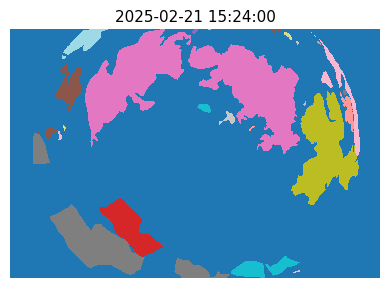

In [3]:
# If you have the merged DataFrame (e.g., asi_color after merge)
# Show the first row:
show_seg_row(seg_df.iloc[169])

In [8]:
# =========================================================
# From asi_seq rows -> tensors for ConvLSTM
#   * Step 1: stack window to X:[T,3,H,W], Y_seg:[T,H,W]
#   * Step 2: Stage-1 masking of 1–4 timesteps (zero-out)
# =========================================================
import numpy as np, torch, cv2
from torch.utils.data import Dataset, DataLoader

# ---- image & mask helpers ----
def _imread_rgb(path):
    import cv2
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    if im is None: return None
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def _ensure_np_img(img_like, fallback_path):
    """Accepts np.ndarray or loads from path; returns np.ndarray or None."""
    if isinstance(img_like, np.ndarray):
        return img_like
    if fallback_path is not None:
        return _imread_rgb(fallback_path)
    return None

def _resize_img(img, size_hw):
    H, W = size_hw
    return cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)

def _resize_mask(mask, size_hw):
    H, W = size_hw
    return cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)

def _apply_sky_mask_to_img(img, sky_mask):
    # sky_mask: HxW uint8, 1=sky, 0=non-sky
    if sky_mask is None: return img
    m = sky_mask.astype(bool)[..., None]
    return img * m

def _to_tensor_img(img):
    if img.dtype != np.float32:
        img = img.astype(np.float32) / 255.0
    return torch.from_numpy(img.transpose(2,0,1))  # [3,H,W] float32

def _to_tensor_mask(mask):
    return torch.from_numpy(mask.astype(np.int64)) # [H,W] long (with -1)

# ---- core: stack one asi_seq row ----
def stack_window(row, out_hw=(512,512), apply_sky_to_inputs=True, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    """
    row: one row from asi_seq (with lists: images, seg_masks, sky_masks, filepaths, timestamps)
    returns:
      X  : [T,3,H,W] float32, normalized
      Y  : [T,H,W]   long (seg labels with -1 ignore), or None if no labels at all
      SKY: [T,H,W]   uint8 (1=sky) or None if unavailable
      ts : list[pd.Timestamp]
    """
    imgs      = row["images"]
    segs      = row.get("seg_masks", [None]*len(imgs))
    sky_list  = row.get("sky_masks", [None]*len(imgs))
    fpaths    = row.get("filepaths", [None]*len(imgs))
    ts        = row["timestamps"]

    Ht, Wt = out_hw
    X_list, Y_list, SKY_list = [], [], []
    has_any_label = False
    for im_like, seg_like, sky_like, fp in zip(imgs, segs, sky_list, fpaths):
        im = _ensure_np_img(im_like, fp)
        if im is None:
            im = np.zeros((Ht, Wt, 3), np.uint8)
            sky_resized = None
        else:
            im = _resize_img(im, out_hw)
            sky_resized = _resize_mask(sky_like, out_hw) if isinstance(sky_like, np.ndarray) else None
            if apply_sky_to_inputs:
                im = _apply_sky_mask_to_img(im, sky_resized)

        # label
        if isinstance(seg_like, np.ndarray):
            lab = _resize_mask(seg_like, out_hw).astype(np.int16)
            has_any_label = True
        else:
            lab = np.full(out_hw, -1, dtype=np.int16)  # ignore if missing

        X_list.append(_to_tensor_img(im))
        Y_list.append(_to_tensor_mask(lab))
        SKY_list.append(torch.from_numpy(sky_resized) if isinstance(sky_resized, np.ndarray) else None)

    X = torch.stack(X_list, 0)  # [T,3,H,W]
    Y = torch.stack(Y_list, 0) if has_any_label else None
    SKY = None if all(s is None for s in SKY_list) else torch.stack(
        [s if s is not None else torch.ones(out_hw, dtype=torch.uint8) for s in SKY_list], 0
    )

    # normalize
    mean_t = torch.tensor(mean).view(1,3,1,1)
    std_t  = torch.tensor(std).view(1,3,1,1)
    X = (X - mean_t) / std_t

    return X, Y, SKY, ts

# ---- Stage-1: random “mimic erase” 1–4 frames ----
def apply_temporal_mask(X, k_range=(1,4), strategy="zero", token=None):
    """
    X: [T,3,H,W]; returns X_in, mask_time[bool]
    strategy 'zero': set frames to 0
             'token': set frames to constant token (e.g., mean)
    """
    T = X.shape[0]
    k = np.random.randint(k_range[0], k_range[1]+1)
    idx = np.random.choice(T, size=k, replace=False)
    mask_time = torch.zeros(T, dtype=torch.bool)
    mask_time[idx] = True
    X_in = X.clone()
    if strategy == "zero" or token is None:
        X_in[mask_time] = 0.0
    else:
        X_in[mask_time] = token  # e.g., token = learned param or dataset mean
    return X_in, mask_time

# ---- Datasets wired to your asi_seq table ----
class ConvLSTMDatasetStage1(Dataset):
    """Imputation / reconstruction for CAE_Unet_[Bi]ConvLSTM."""
    def __init__(self, asi_seq, out_hw=(512,512), k_range=(1,4), bidirectional=False,
                 apply_sky_to_inputs=True, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
        self.df = asi_seq
        self.out_hw = out_hw
        self.k_range = k_range
        self.bidirectional = bidirectional
        self.apply_sky = apply_sky_to_inputs
        self.mean, self.std = mean, std

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        X, _, _, ts = stack_window(row, out_hw=self.out_hw, apply_sky_to_inputs=self.apply_sky,
                                   mean=self.mean, std=self.std)
        X_in, mask_time = apply_temporal_mask(X, k_range=self.k_range, strategy="zero")
        sample = {
            "x_in": X_in,             # [T,3,H,W] masked input
            "y_img": X,               # [T,3,H,W] target
            "mask_time": mask_time,   # [T]
            "timestamps": ts
        }
        if self.bidirectional:
            sample["x_in_bwd"] = torch.flip(X_in, dims=[0])  # time-reversed for BiConvLSTM
        return sample

class ConvLSTMDatasetStage2(Dataset):
    """Segmentation for CAE_Unet_ConvLSTM."""
    def __init__(self, asi_seq, out_hw=(512,512), apply_sky_to_inputs=True,
                 mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5), ignore_index=-1):
        self.df = asi_seq
        self.out_hw = out_hw
        self.apply_sky = apply_sky_to_inputs
        self.mean, self.std = mean, std
        self.ignore_index = ignore_index

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        X, Y, SKY, ts = stack_window(row, out_hw=self.out_hw, apply_sky_to_inputs=self.apply_sky,
                                     mean=self.mean, std=self.std)
        # if no labels at all in window, keep Y with all -1 so loss ignores it
        if Y is None:
            Y = torch.full((X.shape[0], self.out_hw[0], self.out_hw[1]),
                           fill_value=self.ignore_index, dtype=torch.long)
        return {"x": X, "y_seg": Y, "sky": SKY, "timestamps": ts}


In [9]:
from torch.utils.data import DataLoader

# Example splits (replace with your purged time-split if you already have it)
n = len(asi_seq)
train_seq = asi_seq.iloc[:int(0.7*n)]
val_seq   = asi_seq.iloc[int(0.7*n):]

# Stage-1 (imputation) loaders
train_impute = ConvLSTMDatasetStage1(train_seq, out_hw=(512,512), k_range=(1,4), bidirectional=True)
val_impute   = ConvLSTMDatasetStage1(val_seq,   out_hw=(512,512), k_range=(0,0),  bidirectional=True)  # no masking in val

train_loader_impute = DataLoader(train_impute, batch_size=2, shuffle=True,  num_workers=4, pin_memory=True)
val_loader_impute   = DataLoader(val_impute,   batch_size=2, shuffle=False, num_workers=4, pin_memory=True)

# Stage-2 (segmentation) loaders
train_seg = ConvLSTMDatasetStage2(train_seq, out_hw=(512,512))
val_seg   = ConvLSTMDatasetStage2(val_seq,   out_hw=(512,512))

train_loader_seg = DataLoader(train_seg, batch_size=2, shuffle=True,  num_workers=4, pin_memory=True)
val_loader_seg   = DataLoader(val_seg,   batch_size=2, shuffle=False, num_workers=4, pin_memory=True)


In [10]:
train_seq

,start,end,timestamps,images,seg_masks,seg_paths,sky_masks,has_mask_seq,mask_frames,mask_ratio,length,filepaths
0,2023-03-24 11:32:00,2023-03-24 11:41:00,"[2023-03-24 11:32:00, 2023-03-24 11:33:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2023\03\20230324\20230324_1132_hdr.jpg, S:..."
1,2023-03-24 11:33:00,2023-03-24 11:42:00,"[2023-03-24 11:33:00, 2023-03-24 11:34:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2023\03\20230324\20230324_1133_hdr.jpg, S:..."
2,2023-03-24 11:34:00,2023-03-24 11:43:00,"[2023-03-24 11:34:00, 2023-03-24 11:35:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2023\03\20230324\20230324_1134_hdr.jpg, S:..."
3,2023-03-24 11:35:00,2023-03-24 11:44:00,"[2023-03-24 11:35:00, 2023-03-24 11:36:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2023\03\20230324\20230324_1135_hdr.jpg, S:..."
4,2023-03-24 11:36:00,2023-03-24 11:45:00,"[2023-03-24 11:36:00, 2023-03-24 11:37:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2023\03\20230324\20230324_1136_hdr.jpg, S:..."
...,...,...,...,...,...,...,...,...,...,...,...,...
69513,2025-08-03 09:00:00,2025-08-03 09:09:00,"[2025-08-03 09:00:00, 2025-08-03 09:01:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2025\08\20250803\20250803_0900_hdr.jpg, S:..."
69514,2025-08-03 09:01:00,2025-08-03 09:10:00,"[2025-08-03 09:01:00, 2025-08-03 09:02:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2025\08\20250803\20250803_0901_hdr.jpg, S:..."
69515,2025-08-03 09:02:00,2025-08-03 09:11:00,"[2025-08-03 09:02:00, 2025-08-03 09:03:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2025\08\20250803\20250803_0902_hdr.jpg, S:..."
69516,2025-08-03 09:03:00,2025-08-03 09:12:00,"[2025-08-03 09:03:00, 2025-08-03 09:04:00, 202...","[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[True, True, True, True, True, True, True, Tru...",10,1.0,10,"[S:\2025\08\20250803\20250803_0903_hdr.jpg, S:..."
